In [1]:
import os, sys, copy, time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
import multiprocessing
from functools import partial
import cv2
import skimage.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torchaudio.transforms as AT
from torch.utils.data import  Dataset, TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
from typing import Type, Any, Callable, Union, List, Optional
from IPython.display import HTML
from IPython import display
import librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split

random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

print(torch.__version__)

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


1.9.0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
device

device(type='cuda')

### Parameters

In [3]:
dataset_list = ["Dataset1"]
model_save_dir = "./Trained_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print('"%s" has been created.'%(model_save_dir))
else:
    print("The folder already exists.")    
   
    
batch_size = 256
epochs = 200
print_every = 1
window = 20
step_size = 10
window_type = 'avg'
emb_size = 512
d_model = 512
max_len = 2000

patience = 1000

The folder already exists.


### Get data

In [4]:
x_data_OK = []
y_data_OK = []
x_data_NG = []
y_data_NG = []
for ds in dataset_list:
    ds_path = os.path.join("../Dataset", ds)    
    x_data_OK.append( np.load(os.path.join(ds_path, 'x_data_OK.npy')) )
    y_data_OK.append( np.load(os.path.join(ds_path, 'y_data_OK.npy')) )
    x_data_NG.append( np.load(os.path.join(ds_path, 'x_data_NG.npy')) )
    y_data_NG.append( np.load(os.path.join(ds_path, 'y_data_NG.npy')) )

x_data_OK = np.concatenate(x_data_OK, axis=0)
y_data_OK = np.concatenate(y_data_OK, axis=0)
x_data_NG = np.concatenate(x_data_NG, axis=0)
y_data_NG = np.concatenate(y_data_NG, axis=0)

print(x_data_OK.shape, y_data_OK.shape, x_data_NG.shape, y_data_NG.shape)

(948, 47) (948, 2) (55, 47) (55, 2)


### Split dataset

In [5]:
start_time = time.time()

x_train_OK, x_val_test_OK, y_train_OK, y_val_test_OK = train_test_split(x_data_OK, y_data_OK, test_size=0.398, shuffle=False)
x_train_NG, x_val_test_NG, y_train_NG, y_val_test_NG = train_test_split(x_data_NG, y_data_NG, test_size=0.4, shuffle=False)
x_val_OK, x_test_OK, y_val_OK, y_test_OK = train_test_split(x_val_test_OK, y_val_test_OK, test_size=0.5, shuffle=False)
x_val_NG, x_test_NG, y_val_NG, y_test_NG = train_test_split(x_val_test_NG, y_val_test_NG, test_size=0.5, shuffle=False)

x_train = np.concatenate([x_train_OK, x_train_NG], axis=0)
y_train = np.concatenate([y_train_OK, y_train_NG], axis=0)
x_val = np.concatenate([x_val_OK, x_val_NG], axis=0)
y_val = np.concatenate([y_val_OK, y_val_NG], axis=0)
x_test = np.concatenate([x_test_OK, x_test_NG], axis=0)
y_test = np.concatenate([y_test_OK, y_test_NG], axis=0)

print(x_train_OK.shape, x_val_OK.shape, x_test_OK.shape)
print(x_train_NG.shape, x_val_NG.shape, x_test_NG.shape)
print(x_train.shape, x_val.shape, x_test.shape)

print(y_train_OK.shape, y_val_OK.shape, y_test_OK.shape)
print(y_train_NG.shape, y_val_NG.shape, y_test_NG.shape)
print(y_train.shape, y_val.shape, y_test.shape)

print("--- %s seconds ---"%(time.time()-start_time))

(570, 47) (189, 47) (189, 47)
(33, 47) (11, 47) (11, 47)
(603, 47) (200, 47) (200, 47)
(570, 2) (189, 2) (189, 2)
(33, 2) (11, 2) (11, 2)
(603, 2) (200, 2) (200, 2)
--- 0.004005908966064453 seconds ---


In [6]:
x_train = torch.tensor(x_train).type(torch.float)
y_train = torch.tensor(y_train).type(torch.float )
x_val = torch.tensor(x_val).type(torch.float)
y_val = torch.tensor(y_val).type(torch.float )
x_test = torch.tensor(x_test).type(torch.float)
y_test = torch.tensor(y_test).type(torch.float )

y_train = y_train.view(-1, 2)
y_val = y_val.view(-1, 2)
y_test = y_test.view(-1, 2)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([603, 47]) torch.Size([200, 47]) torch.Size([200, 47])
torch.Size([603, 2]) torch.Size([200, 2]) torch.Size([200, 2])


In [7]:
val_ds = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
print(val_ds[0][0].shape, val_ds[0][1].shape)

torch.Size([47]) torch.Size([2])


In [8]:
class DefectInspector0(torch.nn.Module):
    def __init__(self,                            
                 in_size: int = 47,
                 out_size: int = 2,                                 
                 dropout: float = 0.1
                ):
        super(DefectInspector0, self).__init__()

        self.name = 'DefectInspector0'        
        self.out_size = out_size
        
        self.linear1 = torch.nn.Linear(in_size, 200)
        self.bn1 = torch.nn.BatchNorm1d(200)
        self.relu1 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear2 = torch.nn.Linear(200, 200)
        self.bn2 = torch.nn.BatchNorm1d(200)
        self.relu2 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear3 = torch.nn.Linear(200, 200)
        self.bn3 = torch.nn.BatchNorm1d(200)
        self.relu3 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.final_linear = torch.nn.Linear(200, out_size, bias=True)  

    def forward(self, src: torch.Tensor): # src : (B, S, F)   
        
        out = self.linear1(src)       # (B, S, emb_size)      
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.linear2(out)       # (B, S, emb_size)      
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.linear3(out)       # (B, S, emb_size)      
        out = self.bn3(out)
        out = F.relu(out)
        
        return self.final_linear(out)       # (B, S, emb_size)      

In [9]:
model = DefectInspector0(in_size=x_val.shape[1],
                         out_size=y_val.shape[1])

# existing_model_path = None
# checkpoint = None

load_model = True
if load_model:
    try:        
#         model = torch.load(os.path.join(model_save_dir, 'params-100.pk'))
        checkpoint = torch.load(os.path.join(model_save_dir, 'params-1000.pk')) 
        model.load_state_dict(checkpoint['model_state_dict'])
        print("The model has been loaded.")
    except:
        print("There are no models.")
        load_model = False
 
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0,1])
model.to(device)

print("-"*50)        

There are no models.
--------------------------------------------------


100 0.002539760439620896
200 1.308357112089361e-06


C:\Anaconda3\envs\ml\lib\site-packages\torch\optim\lr_scheduler.py:971: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


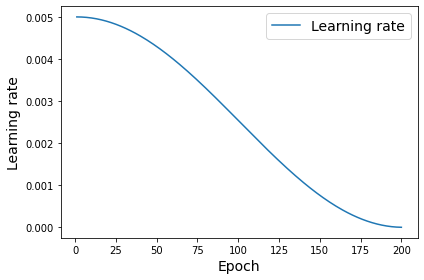

In [10]:
import transformers

#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, betas=(0.9, 0.98), eps=1e-09)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)                    
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001, last_epoch=-1, verbose=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(epochs/1), T_mult=1, eta_min=0.000001, last_epoch=-1, verbose=False)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=400, T_mult=1, eta_max=0.0001, T_up=50, gamma=1.0)
# optimizer = transformers.AdamW(model.parameters(), lr=0.005)
# scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs, num_cycles=1, last_epoch=-1)

epoch_li = []
lr_li = []
last_epoch = 10
for epoch in range(1, last_epoch+1):
    lr = scheduler.get_lr()[0]    
    epoch_li.append(epoch)
    lr_li.append(lr)
    scheduler.step(epoch)        
#     print(epoch, lr)
for epoch in range(last_epoch+1, epochs+1):
    
    lr = scheduler.get_lr()[0]        
    epoch_li.append(epoch)
    lr_li.append(lr)

    scheduler.step(epoch)        
    if epoch%100==0 :
        print(epoch, lr)

# plt.title("Learning rate", fontsize=18) 
plt.plot( epoch_li, lr_li, label='Learning rate')
plt.xlabel( "Epoch", fontsize=14)
plt.ylabel( "Learning rate", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig( os.path.join(model_save_dir, 'learning-rate.jpg') , dpi=199) 
plt.show()

In [11]:
def evaluate(model, data_loader): 
    loss_sum = 0    
    criterion = nn.BCELoss()# nn.CrossEntropyLoss() #nn.MSELoss()
    nIter = 0
    with torch.no_grad(): 
        model.eval()   
        for i, data in enumerate(data_loader):
            output = model(data[0].to(device))            
            loss = criterion(F.softmax(output, dim=1), data[1].to(device))
            loss_sum += loss   
            nIter+=1            
    model.train()
    return loss_sum.item()/nIter

In [12]:
def train(train_loader, val_loader, optimizer, scheduler ):
    print("Learning start...")
    train_start = time.time()
        
    criterion = nn.BCELoss()#nn.CrossEntropyLoss()#nn.MSELoss()
        
    epoch_start = 1    
    train_loss_li = []
    val_loss_li = []    
    time_taken = 0.0    
    best_train_losses = np.ones(10)*float('inf')
    best_val_losses = np.ones(10)*float('inf')
            
    if load_model:
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']+1             
        train_loss_li = checkpoint['train_loss_li']
        val_loss_li = checkpoint['val_loss_li']
        best_train_losses = np.sort(np.array(train_loss_li))[:10]
        best_val_losses = np.sort(np.array(val_loss_li))[:10]
        time_taken = checkpoint['time']
        print('start epoch : %d'%(epoch_start))
        print('best train loss : %f'%(best_train_losses.min()))
        print('best val loss : %f'%(best_val_losses.min()))
        print("="*50)
    
    for epoch in range(1, epoch_start):
        lr = scheduler.get_lr()[0]            
        scheduler.step(epoch)   

    patience_iter = 0
    #sigmoid = nn.Sigmoid()
    for epoch in range(epoch_start, epochs+1):
        epoch_start = time.time()
        print("Epoch %d start.-------------------------------------------"%(epoch))
        
        #best_model_weights = copy.deepcopy(model.state_dict())
        #best_accuracy = 0.0        
        
        nIter = 0
        train_loss = 0
        model.train()         
        
        for i, (inputs, targets) in enumerate(tqdm(train_loader)):
            # print(inputs.size())
            # print(targets.type())

            optimizer.zero_grad()                        
            output = model(inputs.to(device))   
#             print(F.softmax(output))            
            loss = criterion(F.softmax(output, dim=1), targets.to(device))
            
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()        
            train_loss += loss
            nIter+=1

        train_loss = train_loss.item()/nIter
        val_loss = evaluate(model, val_loader)
                
        train_loss_li.append(train_loss)            
        val_loss_li.append(val_loss)
        
#         train_best1 = best_train_losses.min()
#         train_best10 = best_train_losses.max()
        val_best1 = best_val_losses.min()
        val_best10 = best_val_losses.max()
        
#         if ( epoch % print_every==0  ) :    
        if val_loss<val_best10 or (epoch==epochs) or (epoch%50==0): 
            model_to_be_saved = model
            if torch.cuda.device_count() > 1:     
                model_to_be_saved = model.module  

            save_param_path = os.path.join(model_save_dir, "params-" + str(epoch) + '.pk')                  
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_to_be_saved.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),                        
                    'train_loss_li': train_loss_li, 
                    'val_loss_li' : val_loss_li,
                    'time' : (time_taken + time.time() - train_start)
                    }, save_param_path)
            #save_model_path = os.path.join(model_save_dir, "model-" + str(epoch) + '.pk')  
            #torch.save(model_to_be_saved, save_model_path)                                          
            
            if (val_loss <= val_best10) :
                best_val_losses[np.argmax(best_val_losses)] = val_loss

            if (val_loss <= val_best1) :
                patience_iter=0
                print( "The best val loss improved from %f to %f"%(val_best1, val_loss))
            else:
                patience_iter+=1

        else:
            patience_iter+=1
            print("val_loss did not improve from %f"%(best_val_losses.min()))
        
        if patience_iter>=patience:
            break
        
        print("=> mse : %f | val_loss : %f | lr : %e -  %fs"%( train_loss, val_loss, scheduler.get_lr()[0], (time.time() - epoch_start)))
        print("=> Time spent : %fs"%( time_taken + time.time() - train_start ) )
        print("-"*50)
        
        # Update learning rate
        scheduler.step(epoch)
        
        if (epoch % 10==0):
            display.clear_output(wait=True)

In [13]:
train_ds = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
print(train_ds[0][0].shape, train_ds[0][1].shape)

torch.Size([47]) torch.Size([2])


In [ ]:
start_time = time.time()
train(train_loader, val_loader, optimizer, scheduler)
print("--- %s seconds ---"%(time.time()-start_time))
print("Training complete")

Epoch 171 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


val_loss did not improve from 0.142797
=> mse : 0.000443 | val_loss : 0.384697 | lr : 2.734292e-04 -  4.274696s
=> Time spent : 729.501954s
--------------------------------------------------
Epoch 172 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.40it/s]


val_loss did not improve from 0.142797
=> mse : 0.000252 | val_loss : 0.386065 | lr : 2.558801e-04 -  4.353736s
=> Time spent : 733.855689s
--------------------------------------------------
Epoch 173 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


val_loss did not improve from 0.142797
=> mse : 0.000671 | val_loss : 0.385875 | lr : 2.388848e-04 -  4.062700s
=> Time spent : 737.918389s
--------------------------------------------------
Epoch 174 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.38it/s]


val_loss did not improve from 0.142797
=> mse : 0.000982 | val_loss : 0.383522 | lr : 2.224475e-04 -  4.206594s
=> Time spent : 742.125983s
--------------------------------------------------
Epoch 175 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


val_loss did not improve from 0.142797
=> mse : 0.000225 | val_loss : 0.379773 | lr : 2.065723e-04 -  4.348124s
=> Time spent : 746.474107s
--------------------------------------------------
Epoch 176 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


val_loss did not improve from 0.142797
=> mse : 0.000277 | val_loss : 0.378175 | lr : 1.912631e-04 -  4.401837s
=> Time spent : 750.875944s
--------------------------------------------------
Epoch 177 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


val_loss did not improve from 0.142797
=> mse : 0.000191 | val_loss : 0.374817 | lr : 1.765237e-04 -  4.235978s
=> Time spent : 755.111922s
--------------------------------------------------
Epoch 178 start.-------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.41it/s]


val_loss did not improve from 0.142797
=> mse : 0.000217 | val_loss : 0.375744 | lr : 1.623576e-04 -  4.268658s
=> Time spent : 759.380580s
--------------------------------------------------
Epoch 179 start.-------------------------------------------


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]